<a href="https://colab.research.google.com/github/tpathanjali/ML/blob/master/Sentiment_analysis_using_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

below will install pydrive to connect to drive and sk learn

# sentiment analysis

In [1]:
!pip install -U -q sklearn
!pip install -U -q PyDrive

    100% |████████████████████████████████| 993kB 19.8MB/s 


Below code will be used to authenticate the google drive to use data on drive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

TrainFile = '1uitbEQqxS1E7B_w1JoxOBM9A-A06kMPT'
downloaded = drive.CreateFile({'id': TrainFile})
downloaded.GetContentFile('twittertrain.txt')
TestFile = '1ZI0pmAytx1JbCKKR4mfdxErQilljYnuA'
downloaded2 = drive.CreateFile({'id': TestFile})
downloaded2.GetContentFile('twitterTST.txt')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



importing necessary **libraries**

In [3]:
import sklearn as sklearn
from string import punctuation
import re
from nltk.corpus import wordnet
import keras as kr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import gensim
from gensim.models.word2vec import Word2Vec 
from wordcloud import WordCloud
from nltk import word_tokenize, sent_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from keras.layers import Embedding
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.layers import SimpleRNN
from keras.layers.wrappers import Bidirectional
from nltk.stem.porter import *
nltk.download('wordnet')


Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**loading the train and test data**

In [0]:
twitter_train=pd.read_csv('twittertrain.txt',sep=',',encoding='latin-1')
twitter_test=pd.read_csv('twitterTST.txt',sep=',',encoding='latin-1')

below code will clean the tweets for further analysis

*   **clean_tweet ** will clear all the unncessary punctuation and url/links
*   **RegexpReplacer** will replace patterns example isnt will be replaced to is not
*   **RepeatReplacer** will remove unnecessary letters in words eg ohhh myyyy godd will be replaced as oh my god
*   **Integrate** will integrate all the above functions to give the output



In [0]:
def clean_tweet(tweet): 
    X= ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d)|(#(\w+))", " ", tweet).split())
    return(X.lower())
replacement_patterns = [(r'its', 'it is'),(r'im', 'i am'),(r'isnt', 'is not'),(r'thats', 'that is'),(r'won\'t', 'will not'),(r'can\'t', 'can not'),(r'i\'m', 'i am'),(r'ain\'t', 'is not'),(r'(\w+)\'ll', '\g<1> will'),(r'(\w+)n\'t', '\g<1> not'),(r'(\w+)\'ve', '\g<1> have'),(r'(\w+)\'s', '\g<1> is'),(r'(\w+)\'re', '\g<1> are'),(r'(\w+)\'d', '\g<1> would')]
class RegexpReplacer(object): 
    def __init__(self, patterns=replacement_patterns): 
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns] 
    def replace(self, text):
        s = text 
        for (pattern, repl) in self.patterns: 
            (s, count) = re.subn(pattern, repl, s) 
        return s
class RepeatReplacer(object): 
    def __init__(self): 
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)') 
        self.repl = r'\1\2\3' 
    def replace(self, word): 
        if wordnet.synsets(word): 
            return word 
        repl_word = self.repeat_regexp.sub(self.repl, word) 
        if repl_word != word: 
            return self.replace(repl_word) 
        else: 
            return repl_word
def integrate(word):
  x=RegexpReplacer()
  y=RepeatReplacer()
  return(" ".join([y.replace(i) for i in clean_tweet(x.replace(word)).split(' ') if len(i) >2]))

a new column in created on existing train dataset, just to compare the original tweet and cleaned tweet. We don't require the original tweet anymore

In [0]:
twitter_train['cleaned']=twitter_train['SentimentText'].apply(integrate)

In [132]:
twitter_train[['Sentiment','SentimentText','cleaned']]

,Sentiment,SentimentText,cleaned
0,0,is so sad for my APL frie...,sad for apl friend
1,0,I missed the New Moon trail...,missed the new moon trailer
2,1,omg its already 7:30 :O,omg already
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga so guna cry have been this dentist sinc...
4,0,i think mi bf is cheating on me!!! ...,think cheating
5,0,or i just worry too much?,just worry too much
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,just chilin
7,0,Sunny Again Work Tomorrow :-| ...,sunny again work tomorrow tonight
8,1,handed in my uniform today . i miss you ...,handed uniform today miss you already
9,1,hmmmm.... i wonder how she my number @-),hm wonder how she number


In [7]:
twitter_train['Sentiment'].value_counts()

1    56457
0    43532
Name: Sentiment, dtype: int64

seems, we have almost equal amount of sentiments for positive and negative sentiments. we can consider 30k of each for training and rest for test. Anyway we have an entirely bigger test dataset for testing

In [0]:

tokenized_tweets=twitter_train['cleaned'].apply(lambda x: x.split(' ') )
removed_tweets=twitter_train['cleaned'].apply(lambda x: x.split(' ') )

In [0]:
for i in range(1,len(tokenized_tweets)):
  if len(tokenized_tweets[i])>5:
    removed_tweets[i]=tokenized_tweets[i]
  else:
    removed_tweets[i]=['0']


In [163]:
removed_tweets

0                                  [sad, for, apl, friend]
1                                                      [0]
2                                                      [0]
3        [omgaga, so, guna, cry, have, been, this, dent...
4                                                      [0]
5                                                      [0]
6                                                      [0]
7                                                      [0]
8             [handed, uniform, today, miss, you, already]
9                                                      [0]
10                                                     [0]
11              [thanks, all, the, haters, face, all, day]
12                                                     [0]
13                                                     [0]
14                                                     [0]
15                      [this, the, way, feel, right, now]
16       [awhe, man, completely, useless, now, funny, a.

In [0]:

stemmer = PorterStemmer()

tokenized_tweets = tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])# stemming
#tokenized_tweets = tokenized_tweets.apply(lambda x: [i for i in x if len(i)>3])

In [0]:

for i in range(len(removed_tweets)):
      removed_tweets[i] = ' '.join(removed_tweets[i])
    
twitter_train['cleaned'] = removed_tweets
#twitter_train2=twitter_train[twitter_train['cleaned'].apply(lambda x: len(x.split(' ')) > 5)]

In [0]:
twitter_train=twitter_train[twitter_train['cleaned'] !='0']

In [12]:
twitter_train.reset_index()

,index,ItemID,Sentiment,SentimentText,cleaned
0,0,1,0,is so sad for my APL frie...,sad for apl friend
1,3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga so guna cry have been this dentist sinc...
2,8,9,1,handed in my uniform today . i miss you ...,handed uniform today miss you already
3,11,12,1,thanks to all the haters up in my face a...,thanks all the haters face all day
4,15,16,0,&lt;-------- This is the way i feel right ...,this the way feel right now
5,16,17,0,awhhe man.... I'm completely useless rt no...,awhe man completely useless now funny all can ...
6,17,18,1,Feeling strangely fine. Now I'm gonna go l...,feeling strangely fine now gona listen some se...
7,18,19,0,HUGE roll of thunder just now...SO scary!!!!,huge roll thunder just now scary
8,19,20,0,I just cut my beard off. It's only been gr...,just cut beard off only been growing for well ...
9,22,23,1,You're the only one who can see this cause...,you are the only one who can see this cause on...


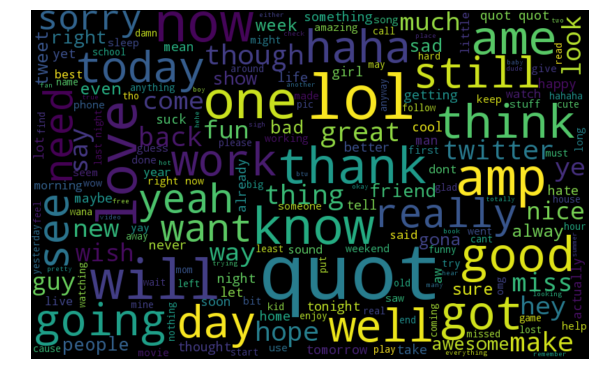

In [170]:
all_words = ' '.join([text for text in twitter_train['cleaned']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [0]:
NUM_OF_WORDS=35000
comments_df_neg = twitter_train[['Sentiment','cleaned']][twitter_train['Sentiment']==0]
comments_df_pos = twitter_train[['Sentiment','cleaned']][twitter_train['Sentiment']==1].sample(n=comments_df_neg.shape[0],replace=False)


In [14]:
print(comments_df_neg.shape)
print(comments_df_pos.shape)

rev_df = pd.concat((comments_df_neg,comments_df_pos))
np.random.seed(42)
rev_df = rev_df.reindex(np.random.permutation(rev_df.index))
rev_df.reset_index(inplace=True, drop=True)

val_data=rev_df.sample(frac=0.1,random_state=42)
train_data=rev_df.drop(val_data.index)

(31983, 2)
(31983, 2)


In [15]:
tokenizer = Tokenizer(num_words=NUM_OF_WORDS,lower=True)
tokenizer.fit_on_texts(twitter_train['cleaned'])
sequences_train = tokenizer.texts_to_sequences(train_data['cleaned'])
sequences_valid=tokenizer.texts_to_sequences(val_data['cleaned'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43958 unique tokens.


In [16]:
X_train = pad_sequences(sequences_train,maxlen=100)
X_val = pad_sequences(sequences_valid,maxlen=100)
y_train = np.asarray(train_data['Sentiment'])
y_val = np.asarray(val_data['Sentiment'])
print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (57569, 100) (6397, 100)
Shape of label train and validation tensor: (57569,) (6397,)


In [0]:
def model_evolution(model,X_test,y_test,threshold) :
  y_hat = model.predict_proba(X_test)
  y_hat = [y_hat > threshold]
  y_hat = y_hat[0].reshape(y_test.shape)
  print(confusion_matrix(y_test,y_hat))
  print(classification_report(y_test,y_hat))

In [0]:
# training:
epochs = 10
batch_size = 128
n_dim = 64
max_input_length = X_train.shape[1] # can be tuned at pad sequence and embedding leyer

#Evolution
threshold = 0.5

In [0]:
def model_evalute(X, Y) :
  # load model
  model_ann_one = load_model(X)
  # load weights
  model_ann_one.load_weights(Y)

  # Model Evolution
  model_evolution(model_ann_one,X_test,y_test,threshold)

In [175]:
# Shallow network- ANN

def ANN_one_hidden(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val) :
  
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(Flatten())
  
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  weight_file="ann.one.weights.best.hdf5"
  model_name ="ann.one.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = ANN_one_hidden(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)


Train on 57569 samples, validate on 6397 samples
Epoch 1/10
57569/57569 [==============================] - 134s 2ms/step - loss: 0.5526 - acc: 0.7133 - val_loss: 0.5038 - val_acc: 0.7555

Epoch 00001: val_acc improved from -inf to 0.75551, saving model to ann.one.weights.best.hdf5
Epoch 2/10
57569/57569 [==============================] - 133s 2ms/step - loss: 0.3738 - acc: 0.8370 - val_loss: 0.5655 - val_acc: 0.7328

Epoch 00002: val_acc did not improve from 0.75551
Epoch 3/10
57569/57569 [==============================] - 134s 2ms/step - loss: 0.1801 - acc: 0.9298 - val_loss: 0.8030 - val_acc: 0.7127

Epoch 00003: val_acc did not improve from 0.75551


In [176]:
def ANN_two_hidden(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val) :
  
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(Flatten())
  
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  weight_file="ann.two.weights.best.hdf5"
  model_name ="ann.two.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
 
  return model_name,weight_file

# model fitting and saving into drive

x, y = ANN_two_hidden(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)


Train on 57569 samples, validate on 6397 samples
Epoch 1/10
57569/57569 [==============================] - 139s 2ms/step - loss: 0.5585 - acc: 0.7042 - val_loss: 0.5056 - val_acc: 0.7508

Epoch 00001: val_acc improved from -inf to 0.75082, saving model to ann.two.weights.best.hdf5
Epoch 2/10
57569/57569 [==============================] - 136s 2ms/step - loss: 0.3788 - acc: 0.8318 - val_loss: 0.5807 - val_acc: 0.7305

Epoch 00002: val_acc did not improve from 0.75082
Epoch 3/10
57569/57569 [==============================] - 135s 2ms/step - loss: 0.1774 - acc: 0.9283 - val_loss: 0.7814 - val_acc: 0.7108

Epoch 00003: val_acc did not improve from 0.75082


In [179]:
def CNN_one_layer(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Conv1D(256, 3, activation='relu'))
  model.add(GlobalMaxPooling1D())
  
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="cnn.one.weights.best.hdf5"
  model_name ="cnn.one.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = CNN_one_layer(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)

Train on 57569 samples, validate on 6397 samples
Epoch 1/10
57569/57569 [==============================] - 68s 1ms/step - loss: 0.5477 - acc: 0.7152 - val_loss: 0.5082 - val_acc: 0.7525

Epoch 00001: val_acc improved from -inf to 0.75254, saving model to cnn.one.weights.best.hdf5
Epoch 2/10
57569/57569 [==============================] - 66s 1ms/step - loss: 0.4315 - acc: 0.8019 - val_loss: 0.5107 - val_acc: 0.7535

Epoch 00002: val_acc improved from 0.75254 to 0.75348, saving model to cnn.one.weights.best.hdf5
Epoch 3/10
57569/57569 [==============================] - 66s 1ms/step - loss: 0.3139 - acc: 0.8679 - val_loss: 0.5707 - val_acc: 0.7394

Epoch 00003: val_acc did not improve from 0.75348


In [180]:
NUM_OF_WORDS=35000
def CNN_lenet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val) :
  
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Conv1D(256, 3, activation='relu'))
  model.add(Conv1D(256, 3, activation='relu'))
  model.add(GlobalMaxPooling1D())
  
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="cnn.lenet.weights.best.hdf5"
  model_name ="cnn.lenet.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = CNN_lenet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)

Train on 57569 samples, validate on 6397 samples
Epoch 1/10
57569/57569 [==============================] - 219s 4ms/step - loss: 0.5540 - acc: 0.7074 - val_loss: 0.5093 - val_acc: 0.7525

Epoch 00001: val_acc improved from -inf to 0.75254, saving model to cnn.lenet.weights.best.hdf5
Epoch 2/10
57569/57569 [==============================] - 214s 4ms/step - loss: 0.4355 - acc: 0.7994 - val_loss: 0.5136 - val_acc: 0.7519

Epoch 00002: val_acc did not improve from 0.75254
Epoch 3/10
57569/57569 [==============================] - 213s 4ms/step - loss: 0.3280 - acc: 0.8606 - val_loss: 0.5728 - val_acc: 0.7436

Epoch 00003: val_acc did not improve from 0.75254


In [0]:
def CNN_alexnet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(256, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(Conv1D(512, 3, activation='relu'))
 # model.add(Conv1D(512, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
 
  model.add(Flatten())
  
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="cnn.alexnet.weights.best.hdf5"
  model_name ="cnn.alexnet.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
 
  return model_name,weight_file

# model fitting and saving into drive

x, y = CNN_alexnet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)

Train on 78358 samples, validate on 8706 samples
Epoch 1/10
78358/78358 [==============================] - 371s 5ms/step - loss: 0.5656 - acc: 0.7094 - val_loss: 0.5071 - val_acc: 0.7437

Epoch 00001: val_acc improved from -inf to 0.74374, saving model to cnn.alexnet.weights.best.hdf5
Epoch 2/10
78358/78358 [==============================] - 368s 5ms/step - loss: 0.4229 - acc: 0.8066 - val_loss: 0.5101 - val_acc: 0.7563

Epoch 00002: val_acc improved from 0.74374 to 0.75626, saving model to cnn.alexnet.weights.best.hdf5
Epoch 3/10
24832/78358 [========>.....................] - ETA: 4:08 - loss: 0.3072 - acc: 0.8694

KeyboardInterrupt: ignored

In [0]:
def CNN_vggnet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(256, 2, activation='relu'))
  model.add(Conv1D(256, 2, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(384, 3, activation='relu'))
  model.add(Conv1D(384, 3, activation='relu'))
  model.add(Conv1D(384, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Flatten())
  
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="cnn.vggnet.weights.best.hdf5"
  model_name ="cnn.vggnet.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = CNN_vggnet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)

In [0]:
def Simple_RNN(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(SimpleRNN(256))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="simplernn.weights.best.hdf5"
  model_name ="simplernn.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = Simple_RNN(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val)

In [18]:
def RNN_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(LSTM(256, dropout=0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="RNN_LSTM.weights.best.hdf5"
  model_name ="RNN_LSTM.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = RNN_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 57569 samples, validate on 6397 samples
Epoch 1/10
57569/57569 [==============================] - 426s 7ms/step - loss: 0.5668 - acc: 0.7014 - val_loss: 0.5081 - val_acc: 0.7525

Epoch 00001: val_acc improved from -inf to 0.75254, saving model to RNN_LSTM.weights.best.hdf5
Epoch 2/10
57569/57569 [==============================] - 425s 7ms/step - loss: 0.4523 - acc: 0.7914 - val_loss: 0.5102 - val_acc: 0.7521

Epoch 00002: val_acc did not improve from 0.75254
Epoch 3/10
57569/57569 [==============================] - 422s 7ms/step - loss: 0.3904 - acc: 0.8275 - val_loss: 0.5554 - val_acc: 0.7411

Epoch 00003: val_acc did not improve from 0.75254


In [19]:
def Stacked_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(LSTM(256, dropout=0.2, return_sequences=True))
  
  model.add(LSTM(256, dropout=0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="Stacked_LSTM.weights.best.hdf5"
  model_name ="Stacked_LSTM.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = Stacked_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val)

Train on 57569 samples, validate on 6397 samples
Epoch 1/10
57569/57569 [==============================] - 995s 17ms/step - loss: 0.5504 - acc: 0.7150 - val_loss: 0.5075 - val_acc: 0.7546

Epoch 00001: val_acc improved from -inf to 0.75457, saving model to Stacked_LSTM.weights.best.hdf5
Epoch 2/10
57569/57569 [==============================] - 980s 17ms/step - loss: 0.4523 - acc: 0.7917 - val_loss: 0.5147 - val_acc: 0.7458

Epoch 00002: val_acc did not improve from 0.75457
Epoch 3/10
57569/57569 [==============================] - 988s 17ms/step - loss: 0.3962 - acc: 0.8236 - val_loss: 0.5521 - val_acc: 0.7396

Epoch 00003: val_acc did not improve from 0.75457


In [20]:
def Bidirectional_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Bidirectional(LSTM(256, dropout=0.2)))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="bidirectionl.LSTM.weights.best.hdf5"
  model_name ="bidirectionl.LSTM.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = Bidirectional_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val)

Train on 57569 samples, validate on 6397 samples
Epoch 1/10
57569/57569 [==============================] - 823s 14ms/step - loss: 0.5662 - acc: 0.7044 - val_loss: 0.5052 - val_acc: 0.7572

Epoch 00001: val_acc improved from -inf to 0.75723, saving model to bidirectionl.LSTM.weights.best.hdf5
Epoch 2/10
57569/57569 [==============================] - 821s 14ms/step - loss: 0.4548 - acc: 0.7891 - val_loss: 0.5179 - val_acc: 0.7494

Epoch 00002: val_acc did not improve from 0.75723
Epoch 3/10
57569/57569 [==============================] - 819s 14ms/step - loss: 0.3997 - acc: 0.8226 - val_loss: 0.5325 - val_acc: 0.7461

Epoch 00003: val_acc did not improve from 0.75723


In [1]:
def Bidirectional_stacked_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Bidirectional(LSTM(256, dropout=0.2,return_sequences=True)))
  
  model.add(Bidirectional(LSTM(256, dropout=0.2)))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="Bidirectional_stacked_LSTM.weights.best.hdf5"
  model_name ="Bidirectional_stacked_LSTM.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = Bidirectional_stacked_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val)

NameError: ignored

In [0]:
from keras.models import Model
from keras.layers import Input, concatenate
def multi_cnn(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  
  input_layer = Input(shape=(max_review_length,), dtype='int16', name='input') # supports integers +/- 32.7k 
  
  embedding_layer = Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length) (input_layer)
  drop_embed_layer = SpatialDropout1D(0.2, name='drop_embed')(embedding_layer)

  conv_1 = Conv1D(128, 3, activation='relu', name='conv_1')(drop_embed_layer)
  maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

  conv_2 = Conv1D(128, 3, activation='relu', name='conv_2')(drop_embed_layer)
  maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

  conv_3 = Conv1D(128, 3, activation='relu', name='conv_3')(drop_embed_layer)
  maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

  concat = concatenate([maxp_1, maxp_2, maxp_3])

  dense_layer = Dense(256, activation='relu', name='dense')(concat)
  drop_dense_layer = Dropout(0.2, name='drop_dense')(dense_layer)
  dense_2 = Dense(512, activation='relu', name='dense_2')(drop_dense_layer)
  dropout_2 = Dropout(0.2, name='drop_dense_2')(dense_2)

  predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

  model = Model(input_layer, predictions)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  weight_file="multi_cnn.weights.best.hdf5"
  model_name ="multi_cnn.LSTM.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)